In [ ]:
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AddedToken, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Model
from text_utils import custom_data_gen, DBpedia, TextProcessor, TextTokenizer
from tqdm.autonotebook import tqdm
from utils import META_PATH

In [28]:
LR = 1e-4
LR_DECAY = 0.8
MIN_LR = 5e-6
N_EPOCHS = 20
PLATEAU = 3
BATCH_SIZE = 64
MAX_LEN = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({
    "pad_token": AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True)
})

0

In [ ]:
## to do
## re split: part of train use for quantization, part of test use for examples

## just change contents of csv

__Plan__

__1.1. re split data 19:05 DONE__
  
__1.2. new dataloaders 19:20 DONE__

__2. write train loop 19:40__

__3. train gpt2 several attention layers 20:00__

__1. re split data__

In [ ]:
pwd

In [4]:
# data = DBpedia(root="/root/quantized_nn/dbpedia_data")

# train_data = pd.read_csv("dbpedia_data/dbpedia_csv/train.csv", header=None)
# test_data = pd.read_csv("dbpedia_data/dbpedia_csv/test.csv", header=None)

# train_data.columns = ["class", "header", "content"]
# test_data.columns = ["class", "header", "content"]



# train_data, quant_data = train_test_split(train_data,
#                                           test_size=0.2,
#                                           stratify=train_data["class"],
#                                           random_state=1234567890)
# test_data, infer_data = train_test_split(test_data,
#                                          test_size=0.5,
#                                          stratify=test_data["class"],
#                                          random_state=1234567890)

# os.mkdir("data_db/")
# train_data.to_csv("data_db/train.csv", index=None)
# quant_data.to_csv("data_db/quant.csv", index=None)
# test_data.to_csv("data_db/test.csv", index=None)
# infer_data.to_csv("data_db/infer.csv", index=None)

FileExistsError: [Errno 17] File exists: 'data_db/'

__2. NEW DATALOADERS__

In [ ]:
# data_dir = "data_db/"

In [30]:
train_data = pd.read_csv("data_db/train.csv")
quant_data = pd.read_csv("data_db/quant.csv")
test_data = pd.read_csv("data_db/test.csv")
infer_data = pd.read_csv("data_db/infer.csv")
tst_0_data = train_data.iloc[:320]
tst_1_data = train_data.iloc[320:2*320]

In [31]:
data_train = ((row[0], row[2]) for row in train_data.values)
data_quant = ((row[0], row[2]) for row in quant_data.values)
data_test = ((row[0], row[2]) for row in test_data.values)
data_infer = ((row[0], row[2]) for row in infer_data.values)
data_tst_0 = ((row[0], row[2]) for row in tst_0_data.values)
data_tst_1 = ((row[0], row[2]) for row in tst_1_data.values)

In [32]:
def init_gpt2():
    gpt2_config = GPT2Config(vocab_size=len(tokenizer.get_vocab()))
    setattr(gpt2_config, "pad_token_id", 50256)
    model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path="gpt2",
                                                          config=gpt2_config)
    new_score = nn.Sequential(
        nn.Linear(in_features=768, out_features=14, bias=False),
        nn.Sigmoid()
    )

    setattr(model, "score", new_score)
    return freeze_layers(model).to(DEVICE)
    
    
def freeze_layers(model,
                  except_last=37):
    num_layers = sum(1 for p in model.parameters())
    for num, (nam, p) in enumerate(model.named_parameters()):
        if num >= num_layers - except_last:
            p.requires_grad = True
        else:
            p.requires_grad = False
    return model

In [33]:
class Trainer:
    
    @staticmethod
    def rnd(x):
        return np.round(float(x), 5)
    
    def __init__(self,
                 model,
                 train_data,
                 test_data,
                 batch_size,
                 n_epochs,
                 plateau,
                 lr,
                 lr_decay,
                 min_lr,
                 device,
                 res_path,
                 loss_fn=None,
                 ):
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.plateau = plateau
        self.lr = lr
        self.lr_decay = lr_decay
        self.min_lr = min_lr
        self.device = device
        self.res_path = res_path
        
        self.optimizer = optim.Adam(self.model.parameters(), self.lr)
        self.loss_fn = nn.CrossEntropyLoss()
        if loss_fn:
            self.loss_fn = getattr(nn, loss_fn)()
        self.history = {}
        self.no_gain = 0
    
    def _dump_history(self):
        with open(self.res_path, "w") as f:
            json.dump(self.history, f)
    
    def _update_optimizer(self):
        if self.lr * self.lr_decay >= self.min_lr:
            print(f"LR reduced on plateau from {self.lr} to {self.lr*self.lr_decay}")
            self.lr *= self.lr_decay
        else:
            print(f"LR will no longer be reduced: current value is {self.min_lr}")
            self.lr = self.min_lr
        self.optimizer = optim.Adam(self.model.parameters(), self.min_lr)
        self.no_gain = 0
            
    def _clear_previous_best(self):
        for file in os.listdir():
            if "gpt2_best_epoch" in file:
                os.remove(file)
    
    def _save_best_model(self,
                         epoch,
                         loss):
        self._clear_previous_best()
        filename = f"gpt2_best_epoch_{epoch}_loss_{loss}.pt"
        torch.save(self.model.state_dict(), filename)
        
    
    def _update_history(self,
                        stats):
        loss_trn, acc_trn, loss_val, acc_val = stats
        print(f"train loss - {loss_trn} , train acc - {acc_trn}")
        print(f"val.loss - {loss_val}, val.acc - {acc_val}")
        self.history["loss_trn"].append(self.rnd(loss_trn))
        self.history["acc_trn"].append(self.rnd(acc_trn))
        self.history["loss_val"].append(self.rnd(loss_val))
        self.history["acc_val"].append(self.rnd(acc_val))
        
    def _plot_history(self):
        plt.subplots(figsize=(20,6))
        plt.subplot(1,2,1)
        plt.plot(range(len(self.history["loss_trn"])), 
                           self.history["loss_trn"], 
                           color=(0,0,1), 
                           alpha=0.5,
                           label="Train.loss")
        plt.plot(range(len(self.history["loss_val"])), 
                           self.history["loss_val"], 
                           color=(1,0,0), 
                           alpha=0.5,
                           label="Val.loss")
        plt.grid()
        plt.xlim(0, self.n_epochs+1)
        plt.title("Loss dynamics")
        plt.legend(fontsize=14)
        plt.subplot(1,2,2)
        plt.plot(range(len(self.history["acc_trn"])), 
                           self.history["acc_trn"], 
                           color=(0,0,1), 
                           alpha=0.5,
                           label="Train.acc.")
        plt.plot(range(len(self.history["acc_val"])), 
                           self.history["acc_val"], 
                           color=(1,0,0), 
                           alpha=0.5,
                           label="Val.acc")
        plt.grid()
        plt.xlim(0, self.n_epochs+1)
        plt.title("Accuracy dynamics")
        plt.legend(fontsize=14)
        plt.show()
    
    def train(self):
        if os.path.exists(self.res_path):
            os.remove(self.res_path)
        self.history = {
            "loss_trn": [],
            "loss_val": [],
            "acc_trn": [],
            "acc_val": [],
            "best_loss": 1e10
        }
        for epoch in range(1, self.n_epochs+1):
            stats = self.train_epoch(epoch)
            if self.rnd(stats[2]) < self.history["best_loss"]:
                self.history["best_loss"] = self.rnd(stats[2])
                self.no_gain = 0
                self._save_best_model(epoch,
                                      self.rnd(stats[2]))
            else:
                self.no_gain += 1
            if self.no_gain == self.plateau:
                self._update_optimizer()
            self._update_history(stats)
            self._plot_history()
            self._dump_history()
        return self.model
            
    def train_epoch(self,
                    epoch):
        loss_trn = 0
        acc_trn = 0
        batch_trn = 0
        loss_val = 0
        acc_val = 0
        batch_val = 0
        self.model.to(self.device)
        self.model.train()
        data_tst_0 = ((row[0], row[2]) for row in self.train_data.values)
        data_tst_1 = ((row[0], row[2]) for row in self.test_data.values)
        print(f"Epoch {epoch}:")
        self.model.train()
        for num, (x, y) in enumerate(tqdm(custom_data_gen(data_tst_0,
                                                          tokenizer,
                                                          MAX_LEN,
                                                          self.batch_size,
                                                          self.device)),
                                     start=1):
            loss, acc = self.run_batch(x,
                                  y)
            batch_trn += 1
            loss_trn += loss.item()
            acc_trn += acc.item()
            if num % 5 == 0:
                print(f"Train loss - {self.rnd(loss_trn/num)}, train acc - {self.rnd(acc_trn/num)}", end="\r")
        
        self.model.eval()
        for num, (x, y) in enumerate(tqdm(custom_data_gen(data_tst_1,
                                                          tokenizer,
                                                          MAX_LEN,
                                                          self.batch_size,
                                                          self.device)),
                                     start=1):
            with torch.no_grad():
                loss, acc = self.run_batch(x,
                                           y,
                                           train=False)
                batch_val += 1
                loss_val += loss.item()
                acc_val += acc.item()
                if num % 5 == 0:
                    print(f"Val loss - {self.rnd(loss_val/num)}, val acc - {self.rnd(acc_val/num)}", end="\r")
        clear_output()
        return loss_trn / batch_trn, acc_trn / batch_trn, loss_val / batch_val, acc_val / batch_val
    
    def run_batch(self,
                  x,
                  y,
                  train=True):
        x = x.to(self.device)
        y = y.to(self.device)
        self.optimizer.zero_grad()
        preds = self.model(x).logits
        loss = self.loss_fn(preds, y.long())
        acc = torch.sum(torch.argmax(preds, dim=-1) == y) / self.batch_size
        if train:
            loss.backward()
            self.optimizer.step()
        return loss, acc
    

train loss - 1.797860581125532 , train acc - 0.9195803571428571
val.loss - 1.805350885941432, val.acc - 0.914320054945055


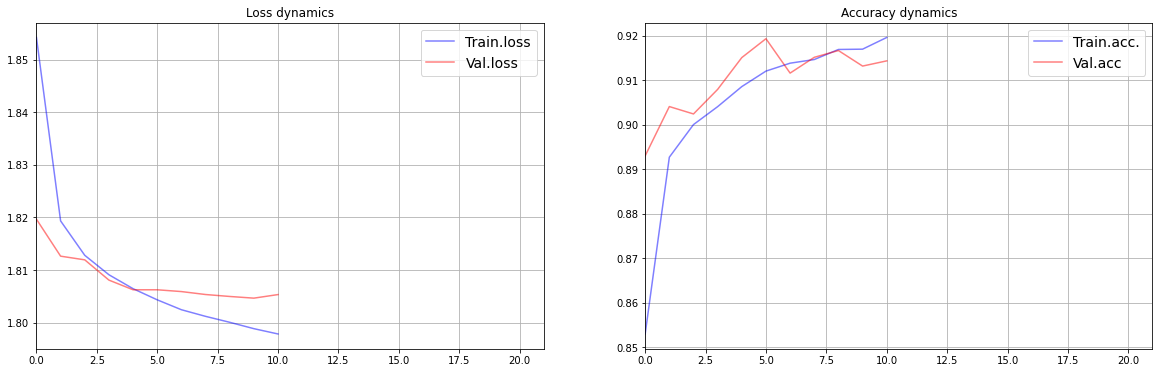

Epoch 12:


0it [00:00, ?it/s]

In [ ]:
model = init_gpt2()
trainer = Trainer(model,
                  train_data,
                  test_data,
                  BATCH_SIZE,
                  n_epochs=N_EPOCHS,
                  plateau=PLATEAU,
                  lr=LR,
                  lr_decay=LR_DECAY,
                  min_lr=MIN_LR,
                  device=DEVICE,
                  res_path="results_gpt2_base.json")
model_trained = trainer.train()

__transformers search__

1. models/gpt2/modeling_gpt2.py class GPT2ForSequenceClassification(GPT2PreTrainedModel)
2. models/gpt2/modeling_gpt2.py class GPT2PreTrainedModel(PreTrainedModel)
3. modeling_utils.py class PreTrainedModel(nn.Module, ModuleUtilsMixin, GenerationMixin, PushToHubMixin)
4. modeling_utils.py class ModuleUtilsMixin
5. generation_utils.py class GenerationMixin
6. file_utils.py class PushToHubMixin
7. models/gpt2/modeling_gpt2.py class GPT2Model(GPT2PreTrainedModel) (maybe embedding quantization can be ussed)
8. models/gpt2/modeling_gpt2.py class GPT2Block(nn.Module)
9. models/gpt2/modeling_gpt2.py class GPT2Attention(nn.Module) (__modify this to quantize attention block__)

In [ ]:
all_params = sum(torch.mul(*p.view(1,-1).size()) for p in model.parameters() if len(p.size()) > 1).item()

In [ ]:
all_params

In [ ]:
all_params

In [ ]:
768*768

In [ ]:
torch.mul(*torch.Tensor([768, 768]))

In [ ]:
x = p.size()

In [ ]:
torch.mul(*x).item()